<span style="font-size:3em;">Ch8: Using convolutions to Generalize </span>




In [58]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt
import datetime
%matplotlib inline

In [8]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']

In [9]:
data_path = '../data-unversioned/p1ch7/'
cifar10 = torchvision.datasets.CIFAR10(data_path, train=True, download=False,
                                       transform=transforms.Compose([
                                           transforms.ToTensor(),
                                           transforms.Normalize((0.4915, 0.4823, 0.4468),
                                             (0.2470, 0.2435, 0.2616))
                                       ]))
cifar10_val = torchvision.datasets.CIFAR10(data_path, train=False, download=False,
                                       transform=transforms.Compose([
                                           transforms.ToTensor(),
                                           transforms.Normalize((0.4915, 0.4823, 0.4468),
                                             (0.2470, 0.2435, 0.2616))
                                       ]))


In [10]:
label_map = {0: 0, 2: 1}
class_names = ['airplane', 'bird']
cifar2 = [(img, label_map[label])
          for img, label in cifar10
          if label in [0, 2]]
cifar2_val = [(img, label_map[label])
              for img, label in cifar10_val
              if label in [0, 2]]

In [16]:
img, _ = cifar2[0]

output = conv(img.unsqueeze(0))
img.unsqueeze(0).shape, output.shape

(torch.Size([1, 3, 32, 32]), torch.Size([1, 16, 30, 30]))

 Due to the fully connected setup needed to detect the various possible translations of the bird or
airplane in the image, we have both too many parameters (making it easier for the
model to memorize the training set) and no position independence (making it
harder to generalize). There is a solution and it consists of replacing the dense, fully connected affine transformation in our neural network unit with a different linear operation: convolution.

# 8.1 The case for convolutions

We said earlier that taking a 1D view of our input image and multiplying it by an
n_output_features × n_input_features weight matrix, as is done in nn.Linear,
means for each channel in the image, computing a weighted sum of all the pixels multiplied by a set of weights, one per output feature.

 We also said that, if we want to recognize patterns corresponding to objects, like an
airplane in the sky, we will likely need to look at how nearby pixels are arranged, and
we will be less interested in how pixels that are far from each other appear in combination. Essentially, it doesn’t matter if our image of a Spitfire has a tree or cloud or
kite in the corner or not.

 In order to translate this intuition into mathematical form, we could compute the
weighted sum of a pixel with its immediate neighbors, rather than with all other pixels
in the image. This would be equivalent to building weight matrices, one per output
feature and output pixel location, in which all weights beyond a certain distance from
a center pixel are zero. This will still be a weighted sum: that is, a linear operation


## 8.1.1 What convolutions do

For other weights, we would have to find a way to keep
entries in sync that correspond to the same relative position of input and output pixels.
This means we would need to initialize them to the same values and ensure that all these
tied weights stayed the same while the network is updated during training. This way, we
would ensure that weights operate in neighborhoods to respond to local patterns, and
local patterns are identified no matter where they occur in the image.

Of course, this approach is more than impractical. Fortunately, there is a readily
available, local, translation-invariant linear operation on the image: a __convolution.__

__Convolution, or more precisely, discrete convolution__
 (there’s an analogous continuous version that we won’t go into here), is defined for a 2D image as the scalar product of a weight matrix, the kernel, with every neighborhood in the input
 
 

That is, we “translate” the kernel on the i11 location of the input image, and we
multiply each weight by the value of the input image at the corresponding location.
Thus, the output image is created by translating the kernel on all input locations and
performing the weighted sum. For a multichannel image, like our RGB image, the
weight matrix would be a 3 × 3 × 3 matrix: one set of weights for every channel, contributing together to the output values.

 __Note__ that, just like the elements in the weight matrix of nn.Linear, the weights in
the kernel are not known in advance, but they are initialized randomly and updated
through backpropagation. 

__Note__ also that the same kernel, and thus each weight in the
kernel, is reused across the whole image. Thinking back to autograd, this means the use
of each weight has a history spanning the entire image. Thus, the derivative of the loss
with respect to a convolution weight includes contributions from the entire image.



It’s now possible to see the connection to what we were stating earlier: a convolution is
equivalent to having multiple linear operations whose weights are zero almost everywhere except around individual pixels and that receive equal updates during training.
 Summarizing, by switching to convolutions, we get
-  Local operations on neighborhoods
-  Translation invariance
-  Models with a lot fewer parameters

# 8.2 Convolutions in action

 The torch.nn module provides convolutions for 1, 2, and 3 dimensions:
 - nn.Conv1d for time series, 
 - nn.Conv2d for images,
 - nn.Conv3d for volumes or videos.
 
At a minimum, the arguments we
provide to nn.Conv2d are the number of input features (or channels, since we’re dealing with multichannel images: that is, more than one value per pixel), the number of output
features, and the size of the kernel. For instance, for our first convolutional module,
we’ll have 3 input features per pixel (the RGB channels) and an arbitrary number of
channels in the output—say, 16. The more channels in the output image, the more the
capacity of the network. We need the channels to be able to detect many different types
of features. Also, because we are randomly initializing them, some of the features we’ll
get, even after training, will turn out to be useless.2
 Let’s stick to a kernel size of 3 × 3.



It is very common to have kernel sizes that are the same in all directions, so
PyTorch has a shortcut for this: whenever kernel_size=3 is specified for a 2D convolution, it means 3 × 3 (provided as a tuple (3, 3) in Python). For a 3D convolution, it
means 3 × 3 × 3. 

The CT scans we will see in part 2 of the book have a different voxel
(volumetric pixel) resolution in one of the three axes. In such a case, it makes sense to
consider kernels that have a different size for the exceptional dimension. But for now,
we stick with having the same size of convolutions across all dimensions:

In [19]:
conv = nn.Conv2d(3,16,kernel_size=3)
conv

Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))

What do we expect to be the shape of the weight tensor? 

The kernel is of size 3 × 3, so
we want the weight to consist of 3 × 3 parts. 

For a single output pixel value, our kernel
would consider, say, in_ch = 3 input channels, so the weight component for a single
output pixel value (and by translation the invariance for the entire output channel) is
of shape in_ch × 3 × 3. 

Finally, we have as many of those as we have output channels,
here out_ch = 16, so the complete weight tensor is out_ch × in_ch × 3 × 3, in our case
16 × 3 × 3 × 3. The bias will have size 16 (we haven’t talked about bias for a while for
simplicity, but just as in the linear module case, it’s a constant value we add to each
channel of the output image). 

In [4]:
conv.weight.shape, conv.bias.shape

(torch.Size([16, 3, 3, 3]), torch.Size([16]))

 A 2D convolution pass produces a 2D image as output, whose pixels are a weighted
sum over neighborhoods of the input image. As usual, we need to add the zeroth batch dimension with
unsqueeze if we want to call the conv module with one input image, since nn.Conv2d
expects a B × C × H × W shaped tensor as input

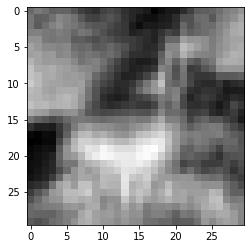

In [18]:
#We’re curious, so we can display the output 
plt.imshow(output[0][0].detach(), cmap='gray')

## 8.2.1 Padding the boundary

If we look at the shape of the output, we can see that the shape has gone from 32x32 to 30x30. This is because the middle of the kernel starts at the top left pixel, so we need to add a boundary/padding to the outside so it can capture the entire picture

By default, PyTorch willslide the convolution kernel within the input picture, getting width - kernel_width +1 horizontal and vertical positions. For odd-sized kernels, this results in images that are one-half the convolution kernel’s width (in our case, 3//2 = 1) smaller on each side. PyTorch gives us the possibility of padding the image by creating ghost pixels around the border that have value zero as far as the convolution is concerned.

In [23]:
conv = nn.Conv2d(3,16,kernel_size=3,padding=1)
output = conv(img.unsqueeze(0))
img.unsqueeze(0).shape, output.shape

(torch.Size([1, 3, 32, 32]), torch.Size([1, 16, 32, 32]))

Note that the sizes of weight and bias don’t change, regardless of whether padding is
used

__There are two main reasons to pad convolutions.__ 

- First, doing so helps us separate
the matters of convolution and changing image sizes, so we have one less thing to
remember.
- Second, when we have more elaborate structures such as skip connections (discussed in section 8.5.3) or the U-Nets we’ll cover in part 2, we want the
tensors before and after a few convolutions to be of compatible size so that we can
add them or take differences. 

## 8.2.2 Detecting features with convolutions

We said earlier that weight and bias are parameters that are learned through backpropagation, exactly as it happens for weight and bias in nn.Linear. However, we can
play with convolution by setting weights by hand and see what happens.
 Let’s first zero out bias, just to remove any confounding factors, and then set
weights to a constant value so that each pixel in the output gets the mean of its neighbors. For each 3 × 3 neighborhood:

In [24]:
with torch.no_grad():
    conv.bias.zero_()
    
with torch.no_grad():
    conv.weight.fill_(1.0/9.0)

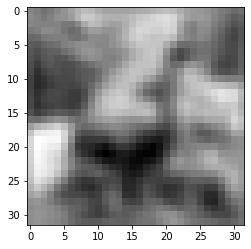

In [26]:
#all the pixels is the average of a neighborhood in the original image
output = conv(img.unsqueeze(0))
plt.imshow(output[0, 0].detach(), cmap='gray')

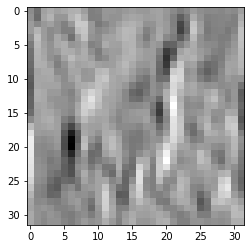

In [28]:
#Lets try another kernel
conv = nn.Conv2d(3, 1, kernel_size=3, padding=1)
with torch.no_grad():
    conv.weight[:] = torch.tensor([[-1.0, 0.0, 1.0],
                                    [-1.0, 0.0, 1.0],
                                    [-1.0, 0.0, 1.0]])
    
output = conv(img.unsqueeze(0))
plt.imshow(output[0, 0].detach(), cmap='gray')

If the kernel is applied on a vertical boundary between two adjacent regions
of different intensity, output of that region will have a high value. If the kernel is applied on a region of
uniform intensity, output will be zero. __It’s an edge-detection kernel:__ the kernel highlights the
vertical edge between two horizontally adjacent regions.

 
 
  With deep learning, we let kernels be estimated from data in whatever way the discrimination is most effective: for instance, in terms of minimizing the negative crossentropy loss between the output and the ground truth that we introduced in section
7.2.5. From this angle, the job of a convolutional neural network is to estimate the kernel of a set of filter banks in successive layers that will transform a multichannel image
into another multichannel image, where different channels correspond to different
features (such as one channel for the average, another channel for vertical edges, and
so on).


## 8.2.3 Looking further with depth and pooling

We recommended the use of small kernels, like 3 × 3, or 5 × 5: that’s peak locality, all right. What about the big picture? How do we know that all structures in our images are 3 pixels or 5 pixels wide? Well, we don’t, because they aren’t. And if they aren’t, how are our networks going to be equipped to see those patterns with larger scope? 


- One possibility could be to use large convolution kernels. Well, sure, at the limit we
could get a 32 × 32 kernel for a 32 × 32 image, but we would converge to the old fully
connected, affine transformation and lose all the nice properties of convolution.


- Another option, which is used in convolutional neural networks, is stacking one convolution after the other and at the same time downsampling the image between successive convolutions.


__DOWNSAMPLING__

Downsampling could in principle occur in different ways. How we compute the value of the output based on the values of the input is up to us. We could:

- __Average the four pixels__. This __average pooling__ was a common approach early on but
has fallen out of favor somewhat.


- __Take the maximum of the four pixels__. This approach, called __max pooling__, is currently
the most commonly used approach, but it has a downside of discarding the
other three-quarters of the data.


- __Perform a strided convolution, where only every Nth pixel is calculated__. A 3 × 4 convolution with stride 2 still incorporates input from all pixels from the previous layer.
The literature shows promise for this approach, but it has not yet supplanted
max pooling.


We will be focusing on max pooling

Intuitively, the output images from a convolution layer, especially since they are followed by an activation just like any other linear layer, tend to have a high magnitude where certain features corresponding to the estimated kernel are detected (such as
vertical lines).

By keeping the highest value in the 2 × 2 neighborhood as the downsampled output, we ensure that the features that are found survive the downsampling,
at the expense of the weaker responses.

Max pooling is provided by the __nn.MaxPool2d module__ (as with convolution, there are
versions for 1D and 3D data). It takes as input the size of the neighborhood over which
to operate the pooling operation. If we wish to downsample our image by half, we’ll want
to use a size of 2, since MaxPool2d uses a stride of 2.

In [35]:
pool = nn.MaxPool2d(2)
pool(output).shape, img.unsqueeze(0).shape

(torch.Size([1, 1, 16, 16]), torch.Size([1, 3, 32, 32]))

Where we use multiple layers of convolutions and pooling, say 2, the first set of kernels operates on small neighborhoods on firstorder, low-level features, while the second set of kernels effectively operates on wider
neighborhoods, producing features that are compositions of the previous features.
This is a very powerful mechanism that provides convolutional neural networks with
the ability to see into very complex scenes


In [36]:
model = nn.Sequential(
nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.Tanh(),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 8, kernel_size=3, padding=1),
            nn.Tanh(),
            nn.MaxPool2d(2),
    
            # ...  Something is missing here
    
            nn.Linear(8 * 8 * 8, 32),
            nn.Tanh(),
            nn.Linear(32, 2))

In [42]:
8*8*8*32

16384

In [39]:
#Lets check how many parameters and ignore the missing portion
params = [p.numel() for p in model.parameters()]
sum(params), params

(18090, [432, 16, 1152, 8, 16384, 32, 64, 2])

## 8.2.4 Putting it all together for our network

What’s missing there is the reshaping step from an 8-channel 8 × 8 image to a 512-
element, 1D vector (1D if we ignore the batch dimension, that is). This could be
achieved by calling view on the output of the last nn.MaxPool2d, but unfortunately, we
don’t have any explicit visibility of the output of each module when we use
nn.Sequential.

# 8.3 Subclassing nn.Module
At some point in developing neural networks, we will find ourselves in a situation where
we want to compute something that the premade modules do not cover. Here, it is something very simple like reshaping, ; but in section 8.5.3, we use the same construction to implement residual connections. So in this section, we learn how to make our own nn.Module subclasses that we can then use just like the prebuilt ones or nn.Sequential.
 
 When we want to build models that do more complex things than just applying one layer after another, we need to leave nn.Sequential for something that gives us added flexibility. PyTorch allows us to use any computation in our model by subclassing nn.Module.
 
 In order to subclass nn.Module, at a minimum we need to define a forward function
that takes the inputs to the module and returns the output. This is where we define our
module’s computation. The name forward here is reminiscent of a distant past, when
modules needed to define both the forward and backward passes we met in section
5.5.1. With PyTorch, if we use standard torch operations, autograd will take care of the
backward pass automatically; and indeed, an nn.Module never comes with a backward.

Typically, our computation will use other modules—premade like convolutions or
customized. To include these submodules, we typically define them in the constructor
__init__ and assign them to self for use in the forward function. They will, at the
same time, hold their parameters throughout the lifetime of our module. Note that you
need to call super().__  init  ___ () before you can do that (or PyTorch will remind you).

## 8.3.1 Our network as an nn.Module

In [43]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Conv2d(3,16, kernel_size=3,padding=1)
        self.act1 = nn.Tanh(),
        self.pool1 = nn.MaxPool2d(2),
        self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.act2 = nn.Tanh(),
        self.pool2 = nn.MaxPool2d(2),
        self.fc1 = nn.Linear(8*8*8, 32)
        self.act3 = nn.Tanh(),
        self.fc2 = nn.Linear(32,2)
        
    def forward(self, x):
        
        out = self.pool1(self.act1(self.conv1(x)))
        out = self.pool2(self.act2(self.conv1(out)))
        out = out.view(-1, 8*8*8)
        out = self.act3(self.fc1(out))
        out = self.fc2(out)
        return out

The Net class is equivalent to the nn.Sequential modelwe built earlier in terms of submodules; but by writing
the forward function explicitly, we can manipulate the output of self.pool3 directly and call view on it to turn it into a B × N vector.

Here we use a subclass of nn.Module to contain our entire model. We could also use subclasses to define new building blocks for more complex networks


__First__
- our goal is reflected by the size of our intermediate values generally
shrinking—this is done by reducing the number of channels in the convolutions, by
reducing the number of pixels through pooling, and by having an output dimension
lower than the input dimension in the linear layers. This is a common trait of
classification networks. However, in many popular architectures like the ResNets we saw
in chapter 2 and discuss more in section 8.5.3, the reduction is achieved by pooling in
the spatial resolution, but the number of channels increases (still resulting in a
reduction in size). It seems that our pattern of fast information reduction works well
with networks of limited depth and small images; but for deeper networks, the decrease
is typically slower

__Second__

-  In one layer, there is not a reduction of output size with regard to input
size: the initial convolution. If we consider a single output pixel as a vector of 32 elements (the channels), it is a linear transformation of 27 elements (as a convolution of
3 channels × 3 × 3 kernel size)—only a moderate increase. In ResNet, the initial convolution generates 64 channels from 147 elements (3 channels × 7 × 7 kernel size).6
So the first layer is exceptional in that it greatly increases the overall dimension (as in
channels times pixels) of the data flowing through it, but the mapping for each output pixel considered in isolation still has approximately as many outputs as inputs.7



## 8.3.2 How PyTorch keeps track of parameters and submodules

Interestingly, assigning an instance of nn.Module to an attribute in an nn.Module, as
we did in the earlier constructor, automatically registers the module as a submodule.

- ___NOTE__ The submodules must be top-level attributes, not buried inside list or
dict instances! Otherwise the optimizer will not be able to locate the submodules (and, hence, their parameters). For situations where your model
requires a list or dict of submodules, PyTorch provides nn.ModuleList and
nn.ModuleDict.



__We can call arbitrary methods of an nn.Module subclass.__ For example, for a model
where training is substantially different than its use, say, for prediction, it may make
sense to have a predict method. Be aware that calling such methods will be similar to
calling forward instead of the module itself—they will be ignorant of hooks, and the
JIT does not see the module structure when using them because we are missing the
equivalent of the __call__ bits shown in section 6.2.1.

 This allows Net to have access to the parameters of its submodules without further
action by the user:

In [44]:
model = Net()

numel_list = [p.numel() for p in model.parameters()]
sum(numel_list), numel_list

(18090, [432, 16, 1152, 8, 16384, 32, 64, 2])

What happens here is that the parameters() call delves into all submodules assigned
as attributes in the constructor and recursively calls parameters() on them. No matter how nested the submodule, any nn.Module can access the list of all child parameters. By accessing their grad attribute, which has been populated by autograd, the optimizer will know how to change parameters to minimize the loss. 



Looking back at the implementation of the Net class, and thinking about the
utility of registering submodules in the constructor so that we can access their parameters, it appears a bit of a waste that we are also registering submodules that have no
parameters, like nn.Tanh and nn.MaxPool2d. Wouldn’t it be easier to call these
directly in the forward function, just as we called view?

## 8.3.3 The functional API

It sure would! And that’s why PyTorch has functional counterparts for every nn module.
By “functional” here we mean “having no internal state”—in other words, “whose output value is solely and fully determined by the value input arguments.” Indeed, torch
.nn.functional provides many functions that work like the modules we find in nn.
But instead of working on the input arguments and stored parameters like the module counterparts, they take inputs and parameters as arguments to the function call.


For instance, the functional counterpart of nn.Linear is nn.functional.linear,
which is a function that has signature linear(input, weight, bias=None). The
weight and bias parameters are arguments to the function.


In [50]:
#we can safely switch to the functional counterparts of pooling and activation, since they have no parameters:

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(8 * 8 * 8, 32)
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
        out = out.view(-1, 8*8*8)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        
        return out

__TIP:__ While general-purpose scientific functions like tanh still exist in
torch.nn.functional in version 1.0, those entry points are deprecated in
favor of functions in the top-level torch namespace. More niche functions
like max_pool2d will remain in torch.nn.functional.

Thus, the functional way also sheds light on what the nn.Module API is all about: a
Module is a container for state in the forms of Parameters and submodules combined
with the instructions to do a forward.
 
 
Whether to use the functional or the modular API is a decision based on style and
taste. When part of a network is so simple that we want to use nn.Sequential, we’re in
the modular realm. When we are writing our own forwards, it may be more natural to
use the functional interface for things that do not need state in the form of parameters.

In chapter 15, we will briefly touch on quantization. Then stateless bits like activations suddenly become stateful because information about the quantization needs to
be captured. This means if we aim to quantize our model, it might be worthwhile to
stick with the modular API if we go for non-JITed quantization. There is one style matter that will help you avoid surprises with (originally unforeseen) uses: 

- if you need several applications of stateless modules (like nn.HardTanh or nn.ReLU), it is probably a
good idea to have a separate instance for each. Reusing the same module appears to
be clever and will give correct results with our standard Python usage here, but tools
analyzing your model may trip over it.

In [51]:
#now lets run out model
model = Net()
model(img.unsqueeze(0))

tensor([[-0.0858, -0.0521]], grad_fn=<AddmmBackward>)

# 8.4 Training our convnet

In [56]:
def training_loop(epochs, optimizer, model, loss_fn, train_loader):
    for epoch in range(epochs):
        train_loss = 0
        for imgs, labels in train_loader:
            outputs = model(imgs)
            loss = loss_fn(outputs, labels)
            
            optimizer.zero_grad()
            
            loss.backward()
            
            optimizer.step()
            
        
            train_loss += loss.item() #important to transform loss to Python # with .item(), to escape the gradients.
            
        if epoch == 1 or epoch % 10 == 0:
            print('{} Epoch {}, Training loss {}'.format(datetime.datetime.now(), 
                                                         epoch,
                                                         train_loss / len(train_loader)))
            

In [53]:
#Lets put the dataset into our dataloader
cifar2_loader = torch.utils.data.DataLoader(cifar2,batch_size=64, shuffle=True)
cifar2_val_loader = torch.utils.data.DataLoader(cifar2_val, batch_size=64, shuffle=False)

In [54]:
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

In [59]:
training_loop(100, optimizer, model, loss_fn, cifar2_loader)

2020-09-16 12:51:40.654118 Epoch 0, Training loss 0.47706636786460876
2020-09-16 12:51:45.990126 Epoch 1, Training loss 0.4424733519554138
2020-09-16 12:52:34.272841 Epoch 10, Training loss 0.31934890151023865
2020-09-16 12:53:28.479971 Epoch 20, Training loss 0.2900182604789734
2020-09-16 12:54:23.978159 Epoch 30, Training loss 0.268887460231781
2020-09-16 12:55:20.128728 Epoch 40, Training loss 0.2516702711582184
2020-09-16 12:56:14.849697 Epoch 50, Training loss 0.23381511867046356
2020-09-16 12:57:11.138372 Epoch 60, Training loss 0.21622593700885773
2020-09-16 12:58:02.287637 Epoch 70, Training loss 0.205137237906456
2020-09-16 12:58:53.539943 Epoch 80, Training loss 0.18898852169513702
2020-09-16 12:59:47.260044 Epoch 90, Training loss 0.17661665380001068


## 8.4.1 Measuring accuracy

In [62]:
def validate_model(model, train_loader, val_loader):
    for name, loader in  [("train", train_loader), ("val", val_loader)]:
        correct = 0
        total = 0
        
        with torch.no_grad(): #we dont want to keep track of gradients during eval
            for imgs, labels in loader:
                outputs = model(imgs)
                _, predicted = torch.max(outputs, dim=1)
                
                total += labels.shape[0]
                correct += int((predicted == labels).sum())
                
        print("Accuracy {}: {:.2f}".format(name , correct / total))

We cast to a Python int—for integer tensors, this is equivalent to using .item(), similar to what we did in the training loop

In [63]:
validate_model(model, cifar2_loader, cifar2_val_loader)

Accuracy train: 0.93
Accuracy val: 0.89


## 8.4.2 Saving and loading our model

In [64]:
torch.save(model.state_dict(), data_path + 'birds_vs_airplanes.pt')

The birds_vs_airplanes.pt file now contains all the parameters of model: that is,
weights and biases for the two convolution modules and the two linear modules. So, no structure—just the weights. This means when we deploy the model in production
for our friend, we’ll need to keep the model class handy, create an instance, and then
load the parameters back into it:

In [65]:
loaded_model = Net()
loaded_model.load_state_dict(torch.load(data_path + 'birds_vs_airplanes.pt'))

<All keys matched successfully>

## 8.4.3 Training on the GPU

We have a net and can train it! But it would be good to make it a bit faster. It is no surprise by now that we do so by moving our training onto the GPU. Using the .to
method we saw in chapter 3, we can move the tensors we get from the data loader to
the GPU, after which our computation will automatically take place there. But we also
need to move our parameters to the GPU. Happily, nn.Module implements a .to function that moves all of its parameters to the GPU (or casts the type when you pass a
dtype argument).

There is a somewhat subtle difference between Module.to and Tensor.to.
- Module.to is in place: the module instance is modified.

- But Tensor.to is out of place
(in some ways computation, just like Tensor.tanh), returning a new tensor


 One implication is that it is good practice to create the Optimizer after moving the parameters to the appropriate device
 
 It is considered good style to move things to the GPU if one is available. A good
pattern is to set the a variable device depending on __torch.cuda.is_available__:

In [68]:
device = (torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu'))

device

device(type='cpu')

In [72]:
#Now we change the loop by moving the tensors we get from the data loader to the GPU by using the Tensor.to method
def training_loop(epochs, optimizer, model, loss_fn, train_loader):
    for epoch in range(1,epochs+1):
        train_loss = 0
        for imgs, labels in train_loader:
            imgs = imgs.to(device=device)
            labels = labels.to(device=device)
            output = model(imgs)
            
            optimizer.zero_grad()
            loss = loss_fn(output, labels)
            
            loss.backward()
            optimizer.step()
            
            
            loss_train = loss.item()
            
            
        if epoch == 1 or epoch % 10 == 0:
            print('{} Epoch {}, Training loss {}'.format(
                                                        datetime.datetime.now(), 
                                                        epoch,
                                                        train_loss / len(train_loader)))

                
model = Net().to(device=device)
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()


training_loop(100, optimizer, model, loss_fn, cifar2_loader)

2020-09-16 13:21:18.908422 Epoch 1, Training loss 0.0
2020-09-16 13:22:07.677763 Epoch 10, Training loss 0.0
2020-09-16 13:23:01.872507 Epoch 20, Training loss 0.0
2020-09-16 13:23:54.519313 Epoch 30, Training loss 0.0
2020-09-16 13:24:45.789868 Epoch 40, Training loss 0.0
2020-09-16 13:25:37.162184 Epoch 50, Training loss 0.0
2020-09-16 13:26:29.021354 Epoch 60, Training loss 0.0
2020-09-16 13:27:22.109561 Epoch 70, Training loss 0.0
2020-09-16 13:28:15.313390 Epoch 80, Training loss 0.0
2020-09-16 13:29:06.121140 Epoch 90, Training loss 0.0
2020-09-16 13:29:57.164484 Epoch 100, Training loss 0.0


For our small network here, we do see a sizable increase in speed. The advantage
of computing on GPUs is more visible for larger models.
 
 There is a slight complication when loading network weights: PyTorch will attempt
to load the weight to the same device it was saved from—that is, weights on the GPU
will be restored to the GPU. As we don’t know whether we want the same device, we
have two options: we could move the network to the CPU before saving it, or move it
back after restoring. It is a bit more concise to instruct PyTorch to override the device
information when loading weights. This is done by passing the map_location keyword
argument to torch.load:

In [73]:
loaded_model = Net().to(device=device)
loaded_model.load_state_dict(torch.load(data_path + 'birds_vs_airplanes.pt',
                                        map_location=device))

<All keys matched successfully>

# 8.5 Model design

We’ve reached the point where we can build a feed-forward convolutional
neural network and train it successfully to classify images. The natural question is,
what now? What if we are presented with a more complicated problem? 


 If we moved to, say, ImageNet, we would find larger, more complex images, where
the right answer would depend on multiple visual clues, often hierarchically organized. For instance, when trying to predict whether a dark brick shape is a remote control or a cell phone, the network could be looking for something like a screen. Plus images may not be our sole focus in the real world, where we have tabular data, sequences, and text. The promise of neural networks is sufficient flexibility to solve problems on all these kinds of data given the proper architecture (that is, the interconnection of layers or modules) and the proper loss function.
 
 
 PyTorch ships with a very comprehensive collection of modules and loss functions
to implement state-of-the-art architectures ranging from feed-forward components to
long short-term memory (LSTM) modules and transformer networks (two very popular architectures for sequential data). Several models are available through PyTorch
Hub or as part of torchvision and other vertical community efforts.


In general, it is beyond the scope of this
book to explore variations on neural network architectures. However, we can build on
the knowledge we’ve accumulated thus far to understand how we can implement almost any architecture thanks to the expressivity of PyTorch. The purpose of this
section is precisely to provide conceptual tools that will allow us to read the latest
research paper and start implementing it in PyTorch—or, since authors often release
PyTorch implementations of their papers, to read the implementations without choking on our coffee.


## 8.5.1 Adding memory capacity: Width

Given our feed-forward architecture, there are a couple of dimensions we’d likely
want to explore before getting into further complications.
- The first dimension is the width of the network: the number of neurons per layer, or channels per convolution.


We can make a model wider very easily in PyTorch. We just specify a larger number of
output channels in the first convolution and increase the subsequent layers accordingly, taking care to change the forward function to reflect the fact that we’ll now
have a longer vector once we switch to fully connected layers:

In [74]:
class NetWidth(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 16, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(16 * 8 * 8, 32)
        self.fc2 = nn.Linear(32, 2)
    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
        out = out.view(-1, 16 * 8 * 8)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

If we want to avoid hardcoding numbers in the definition of the model, we can easily
pass a parameter to init and parameterize the width, taking care to also parameterize
the call to view in the forward function:

In [75]:
class NetWidth(nn.Module):
    def __init__(self, n_chans1=32):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(n_chans1, n_chans1 // 2, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(8 * 8 * n_chans1 // 2, 32)
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
        out = out.view(-1,8*8* self.n_chans1 // 2)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out
    
    
sum(p.numel() for p in model.parameters())

18090

As we increase the size of our model we increase its capacity, and the greater the capacity, the more variability in the inputs the model will be able to manage; but at the same time, the more likely overfitting will be, since the model can use a greater number of parameters to memorize unessential aspects of the input.

## 8.5.2 Helping our model to converge and generalize: Regularization

Training a model involves two critical steps: optimization, when we need the loss to
decrease on the training set; and generalization, when the model has to work not only
on the training set but also on data it has not seen before, like the validation set. The
mathematical tools aimed at easing these two steps are sometimes subsumed under
the label regularization

__KEEPING THE PARAMETERS IN CHECK: WEIGHT PENALTIES__

The first way to stabilize generalization is to add a regularization term to the loss. This
term is crafted so that the weights of the model tend to be small on their own, limiting
how much training makes them grow. In other words, it is a penalty on larger weight
values. This makes the loss have a smoother topography, and there’s relatively less to
gain from fitting individual samples.


 The most popular regularization terms of this kind are __L2 regularization, which is
the sum of squares of all weights in the model__, and __L1 regularization, which is the sum
of the absolute values of all weights in the model__
 Both of them are scaled by a
(small) factor, which is a hyperparameter we set prior to training.


__L2 regularization is also referred to as weight decay.__ The reason for this name is that,
thinking about SGD and backpropagation, the negative gradient of the __L2 regularization term with respect to a parameter w_i__ is __- 2 * lambda * w_i,__ where lambda is the
aforementioned hyperparameter, simply named weight decay in PyTorch. So, adding L2
regularization to the loss function is equivalent to decreasing each weight by an
amount proportional to its current value during the optimization step (hence, the
name weight decay). Note that weight decay applies to all parameters of the network,
such as biases.


In [77]:
def training_loop_l2reg(n_epochs, optimizer, model, loss_fn,
train_loader):
    for epoch in range(1, n_epochs + 1):
        train_loss = 0
        for imgs, labels in  train_loader:
            imgs = imgs.to(device=device)
            labels = labels.to(device=device)
            outputs = model(imgs)
            loss = loss_fn(outputs, labels)
            
            l2_lambda = 0.001
            l2_norm = sum([p.pow(2.0).sum() for p in model.parameters()]) #L1 just replaces pow with abs
            
            loss = loss + l2_lambda * l2_norm
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
        if epoch == 1 or epoch % 10 == 0:
            print('{} Epoch {}, Training loss {}'.format(
                                                        datetime.datetime.now(),
                                                        epoch,
                                                        loss_train / len(train_loader)))

However, the SGD optimizer in PyTorch already has a weight_decay parameter that
corresponds to 2 * lambda, and it directly performs weight decay during the update
as described previously. It is fully equivalent to adding the L2 norm of weights to the
loss, without the need for accumulating terms in the loss and involving autograd. 

__Therefore:__ Weight decay can also be passed to the optimizer

__NOT RELYING TOO MUCH ON A SINGLE INPUT: DROPOUT__


The idea behind dropout is indeed simple: zero out a random fraction of outputs from neurons across the network, where the randomization happens at each training iteration. This procedure effectively generates slightly different models with different neuron topologies at each iteration, giving neurons in the model less chance to coordinate in the memorization process that happens during overfitting. 

- An alternative point of view is that dropout perturbs the features being generated by the model, exerting an effect that is close to augmentation, but this time throughout the network.


In PyTorch, we can implement dropout in a model by adding an __nn.Dropout module__ between the nonlinear activation function and the linear or convolutional module
of the subsequent layer. As an argument, we need to specify the probability with which
inputs will be zeroed out. In case of convolutions, we’ll use the specialized nn.Dropout2d or nn.Dropout3d, which zero out entire channels of the input:

In [78]:
class Net_Dropout(nn.Module):
    def __init__(self):
        super().__init__()
        self.n_chans1 = n_chans1
        
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.conv1_dropout = nn.Dropout2d(p=0.4)
        
        self.conv2 = nn.Conv2d(n_chans1, n_chans1 // 2, kernel_size=3, padding=1)
        self.conv2_dropout = nn.Dropout2d(p=0.4)
        
        self.fc1 = nn.Linear(8 * 8 * n_chans1 // 2, 32)
        self.fc2 = nn.Linear(32, 2)
    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
        out = self.conv1_dropout(out)
        
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2) 
        out = self.conv2_dropout(out)
        
        out = out.view(-1,8*8* self.n_chans1 // 2)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        
        return out

Note that dropout is normally active during training, while during the evaluation of a
trained model in production, dropout is bypassed or, equivalently, assigned a probability equal to zero. This is controlled through the train property of the Dropout
module. Recall that PyTorch lets us switch between the two modalities by calling
- __model.train()__ or  __model.eval()__ 

on any nn.Model subclass. The call will be automatically replicated on the submodules
so that if Dropout is among them, it will behave accordingly in subsequent forward
and backward passes.


__KEEPING ACTIVATIONS IN CHECK: BATCH NORMALIZATION__

The paper for Batch Normalization described a technique that had multiple beneficial effects on training: allowing us to increase the learning rate and make
training less dependent on initialization and act as a regularizer, thus representing an alternative to dropout.

The main idea behind batch normalization is to rescale the inputs to the activations of the network so that minibatches have a certain desirable distribution. Recalling the mechanics of learning and the role of nonlinear activation functions, this
helps avoid the inputs to activation functions being too far into the saturated portion
of the function, thereby killing gradients and slowing training

In practical terms, batch normalization shifts and scales an intermediate input
using the mean and standard deviation collected at that intermediate location over
the samples of the minibatch. The regularization effect is a result of the fact that an
individual sample and its downstream activations are always seen by the model as
shifted and scaled, depending on the statistics across the randomly extracted minibatch. This is in itself a form of principled augmentation. The authors of the paper
suggest that using batch normalization eliminates or at least alleviates the need
for dropout.

Batch normalization in PyTorch is provided through the nn.BatchNorm1D,
nn.BatchNorm2d, and nn.BatchNorm3d modules, depending on the dimensionality of
the input. Since the aim for batch normalization is to rescale the inputs of the activations, the natural location is after the linear transformation (convolution, in this case)
and the activation

In [79]:
class NetBatchNorm(nn.Module):
    def __init__(self, n_chans1=32):
        super().__init__()
        self.n_chans1 = n_chans1
        
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.conv1_batchnorm = nn.BatchNorm2d(num_features=n_chans1)
        
        self.conv2 = nn.Conv2d(n_chans1, n_chans1 // 2, kernel_size=3, padding=1)
        self.conv2_batchnorm = nn.BatchNorm2d(num_features=n_chans1 // 2)
        
        self.fc1 = nn.Linear(8 * 8 * n_chans1 // 2, 32)
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
        out = self.conv1_batchnorm(self.conv1(x))
        out = F.max_pool2d(torch.tanh(out), 2)
        
        out = self.conv2_batchnorm(self.conv2(out))
        out = F.max_pool2d(torch.tanh(out), 2)
        
        out = out.view(-1,8*8* self.n_chans1 // 2)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        
        return out

Just as for dropout, batch normalization needs to behave differently during training
and inference. In fact, at inference time, we want to avoid having the output for a specific input depend on the statistics of the other inputs we’re presenting to the model.
As such, we need a way to still normalize, but this time fixing the normalization
parameters once and for all.
 As minibatches are processed, in addition to estimating the mean and standard
deviation for the current minibatch, PyTorch also updates the running estimates for
mean and standard deviation that are representative of the whole dataset, as an
approximation. This way, when the user specifies
- model.eval()

and the model contains a batch normalization module, the running estimates are frozen and used for normalization. To unfreeze running estimates and return to using
the minibatch statistics, we call model.train(), just as we did for dropout. 

## 8.5.3 Going deeper to learn more complex structures: Depth__

 With depth, the complexity of the function the network is able to approximate generally increases. In regard to computer vision, a shallower network could
identify a person’s shape in a photo, whereas a deeper network could identify the person, the face on their top half, and the mouth within the face. Depth allows a model
to deal with hierarchical information when we need to understand the context in
order to say something about some input.

__SKIP CONNECTIONS__
Depth comes with some additional challenges, which prevented deep learning models
from reaching 20 or more layers until late 2015. Adding depth to a model generally
makes training harder to converge. Let’s recall backpropagation and think about it in the context of a very deep network


The derivatives of the loss function with respect to
the parameters, especially those in early layers, need to be multiplied by a lot of other
numbers originating from the chain of derivative operations between the loss and the
parameter. Those numbers being multiplied could be small, generating ever-smaller
numbers, or large, swallowing smaller numbers due to floating-point approximation.
The bottom line is that a long chain of multiplications will tend to make the contribution of the parameter to the gradient __vanish__, leading to ineffective training of that layer
since that parameter and others like it won’t be properly updated.


 In December 2015, Kaiming He and coauthors presented residual networks (ResNets), an architecture that uses a simple trick to allow very deep networks to be successfully trained That work opened the door to networks ranging from tens of layers to 100 layers in depth, surpassing the then state of the art in computer vision benchmark problems. We encountered residual networks when we were playing with pretrained models in chapter 2. The trick we mentioned is the following: using a skip connection to short-circuit blocks of layers.
 
 
 A skip connection is nothing but the addition of the input to the output of a block of layers. This is exactly how it is done in PyTorch. Let’s add one layer to our simple convolutional model, and let’s use ReLU as the activation for a change

In [80]:
#Lets look at the vanilla model first then compare to a ResNet

class NetDepth(nn.Module):
    def __init__(self, n_chans1=32):
        super().__init__()
        self.n_chans1 = n_chans1
        
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(n_chans1, n_chans1 // 2, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(n_chans1 // 2, n_chans1 // 2, kernel_size=3, padding=1)
        
        self.fc1 = nn.Linear(4 * 4 * n_chans1 // 2, 32)
        self.fc2 = nn.Linear(32, 2)
        
        
    def forward(self, x):
        out = F.max_pool2d(torch.relu(self.conv1(x)), 2)
        out = F.max_pool2d(torch.relu(self.conv2(out)), 2)
        out = F.max_pool2d(torch.relu(self.conv3(out)), 2)
        
        out = out.view(-1,4*4* self.n_chans1 // 2)
        out = torch.relu(self.fc1(out))
        out = self.fc2(out)
        return out

Adding a skip connection a la ResNet to this model amounts to adding the output of
the first layer in the forward function to the input of the third layer:

In [81]:
class NetRes(nn.Module):
    def __init__(self, n_chans1=32):
        super().__init__()
        self.n_chans1 = n_chans1
        
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(n_chans1, n_chans1 // 2, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(n_chans1 // 2, n_chans1 // 2, kernel_size=3, padding=1)
        
        self.fc1 = nn.Linear(4 * 4 * n_chans1 // 2, 32)
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
        out = F.max_pool2d(torch.relu(self.conv1(x)), 2)
        out = F.max_pool2d(torch.relu(self.conv2(out)), 2)
        out1 = out #Here we save the previous layer so we can add it to conv3 (i.e a skip connection)
        
        out = F.max_pool2d(torch.relu(self.conv3(out)) + out1, 2) #add previous layer out1 to this layers output
        
        out = out.view(-1, 4 * 4 * n_chans1 // 2)
        out = torch.relu(self.fc1(out))
        out = self.fc2(out)
        
        return out

In other words, we’re using the output of the first activations as inputs to the last, in
addition to the standard feed-forward path. This is also referred to as __identity mapping.__


So, how does this alleviate the issues with vanishing gradients we were mentioning
earlier?

 Thinking about backpropagation, we can appreciate that a skip connection, or a
sequence of skip connections in a deep network, creates a direct path from the deeper
parameters to the loss. This makes their contribution to the gradient of the loss more
direct, as partial derivatives of the loss with respect to those parameters have a chance
not to be multiplied by a long chain of other operations.


 It has been observed that skip connections have a beneficial effect on convergence
especially in the initial phases of training. Also, the loss landscape of deep residual
networks is a lot smoother than feed-forward networks of the same depth and width.
 It is worth noting that skip connections were not new to the world when ResNets
came along. Highway networks and U-Net made use of skip connections of one form or another. However, the way ResNets used skip connections enabled models of
depths greater than 100 to be amenable to training.
 
 
 Since the advent of ResNets, other architectures have taken skip connections to
the next level. One in particular, __DenseNet__, proposed to connect each layer with several other layers downstream through skip connections, achieving state-of-the-art
results with fewer parameters. By now, we know how to implement something like
DenseNets: just arithmetically add earlier intermediate outputs to downstream intermediate outputs. 


__BUILDING VERY DEEP MODELS IN PYTORCH__

We talked about exceeding 100 layers in a convolutional neural network. How can we
build that network in PyTorch without losing our minds in the process?

The standard strategy is to define a __building block__, such as a __(Conv2d, ReLU, Conv2d) + skip
connection block__, and __then build the network dynamically in a for loop__.


We first create a __module subclass__ whose sole job is to provide the computation for one
block—that is, one group of convolutions, activation, and skip connection:

In [97]:
class ResBlock(nn.Module):
    def __init__(self, n_chans):
        super(ResBlock, self).__init__()
        
        self.conv = nn.Conv2d(n_chans, n_chans, kernel_size=3, 
                              padding=1, bias=False) # Batch norm cancels out effects of Bias so we leave it out
        self.batch_norm = nn.BatchNorm2d(n_chans)
        
        torch.nn.init.kaiming_normal_(self.conv.weight, nonlinearity='relu') 
        
#Uses custom initializations
#.kaiming_normal_ initializes with normal random elements with std as computed in the ResNet paper.
        torch.nn.init.constant_(self.batch_norm.weight, 0.5 )
        torch.nn.init.zeros_(self.batch_norm.bias)
#The batch norm is initialized to produce output distributions that initially have 0 mean and 0.5 variance

    
    def forward(self, x):
        out = self.conv(x)
        out = self.batch_norm(out)
        out = torch.relu(out)
        
        return out + x


In [101]:
block = ResBlock(n_chans=3)
block(img.unsqueeze(0)).shape

torch.Size([1, 3, 32, 32])

 First, in init, we create nn.Sequential containing a list of ResBlock instances.
nn.Sequential will ensure that the output of one block is used as input to the next. It
will also ensure that all the parameters in the block are visible to Net. Then, in forward,
we just call the sequential to traverse the 100 blocks and generate the output:

In [102]:
class NetResDeep(nn.Module):
    def __init__(self,n_chans1=32,n_blocks=10):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        
        self.resblocks = nn.Sequential(
                            *(num_blocks * [ResBlock(n_chans=n_chans1)])
        )
        
        self.fc1 = nn.Linear(8 * 8 * n_chans1, 32)
        self.fc2 = nn.Linear(32, 2)
        
        def forward(self, x):
            out = F.max_pool2d(torch.relu(self.conv1(x)), 2)
            out = self.resblocks(out)
            out = out.view(-1, 8 * 8 * n_chans1)
            out = torch.relu(self.fc1(out))
            out = self.fc2(out)
            
            return out

In the implementation, we parameterize the actual number of layers, which is important for experimentation and reuse. Also, needless to say, backpropagation will work as
expected. Unsurprisingly, the network is quite a bit slower to converge. It is also more fragile in convergence. This is why we used more-detailed initializations and trained
our NetRes with a learning rate of 3e – 3 instead of the 1e – 2 we used for the other
networks. 

(Obviously a lot more work and tuning is needed to converge a 100 layer network on a complicated dataset)

__INITIALIZATION__

Initialization is one of the
important tricks in training neural networks. Unfortunately, for historical reasons,
PyTorch has default weight initializations that are not ideal. People are looking at fixing the situation.


 In the meantime, we need to fix the
weight initialization ourselves. We found that our model did not converge and looked
at what people commonly choose as initialization (a smaller variance in weights; and
zero mean and unit variance outputs for batch norm), and then we halved the output
variance in the batch norm when the network would not converge.

 Weight initialization could fill an entire chapter on its own, but we think that
would be excessive. In chapter 11, we’ll bump into initialization again and use what
arguably could be PyTorch defaults without much explanation. Once you’ve progressed to the point where the details of weight initialization are of specific interest to
you—probably not before finishing this book—you might revisit this topic